In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import os
import requests


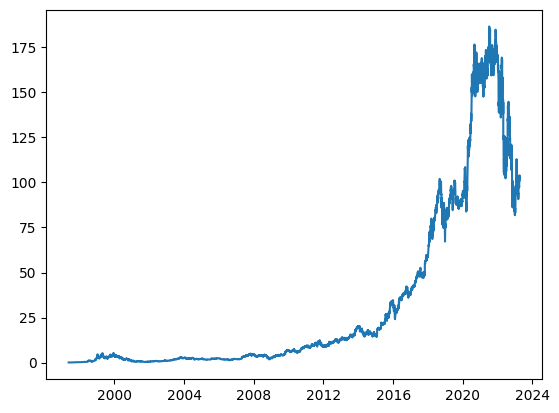

In [87]:
data = pd.read_csv("AMZN.csv")
data = data[['Date','Close']]
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

# #reset it up using my API
# alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
# alphavantage_api_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey={alphavantage_api_key}"
# response = requests.get(alphavantage_api_url)

# data = response.json()
# data = data['Time Series (Daily)']
# data = pd.DataFrame(data).T
# data = data[['4. close']]
# data = data.reset_index()
# data.columns = ['Date','Close']
# data['Date'] = pd.to_datetime(data['Date'])

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [89]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1,n_steps +1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)

    return df


lookback = 7
shift_df = prepare_dataframe_for_lstm(data,lookback)

shift_df_as_np = shift_df.to_numpy()
shift_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shift_df_as_np = scaler.fit_transform(shift_df_as_np)

shift_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [91]:
X = shift_df_as_np[:, 1:]
Y = shift_df_as_np[:, 0]
X.shape, Y.shape

((6509, 7), (6509,))

In [92]:
X = dc(np.flip(X,axis=1))


In [93]:
split_index = int(len(X) * 0.95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [94]:
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [95]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()
X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [96]:
from torch.utils.data import DataLoader, TensorDataset

class TimeSeriesDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

In [97]:
batch_szie = 16

train_loader = DataLoader(train_dataset,batch_size=batch_szie,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_szie,shuffle=False)



In [98]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [99]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_szie = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_szie, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_szie, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1,4,1,1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [100]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [101]:
epoch = 0

In [102]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [103]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [104]:

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.212
Batch 200, Loss: 0.085
Batch 300, Loss: 0.027

Val Loss: 0.051
***************************************************

Epoch: 2
Batch 100, Loss: 0.014
Batch 200, Loss: 0.008
Batch 300, Loss: 0.005

Val Loss: 0.011
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.010
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
*****************

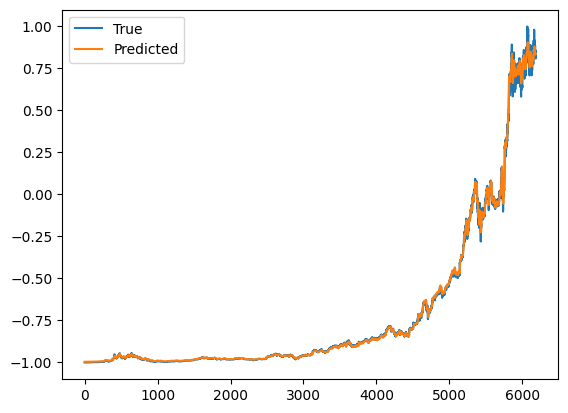

In [105]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='True')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()


In [106]:
#un transform the data

train_predicted = predicted.flatten()
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = train_predicted
dummies = scaler.inverse_transform(dummies)

train_predicted = dc(dummies[:,0])
print(train_predicted)


[  0.45319852   0.4515422    0.45050839 ... 171.2629915  170.89128646
 171.18424401]


In [107]:
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_Y_train = dc(dummies[:,0])
print(new_Y_train)


[7.91646265e-02 7.65634249e-02 7.52572660e-02 ... 1.69091505e+02
 1.73315001e+02 1.68871003e+02]


In [ ]:
plt.plot(new_Y_train, label='Actual Close Price')
plt.plot(train_predicted, label='Predicted Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 58.54764646,  58.82736206,  59.32203503,  59.51095698,
        59.72711433,  59.8074183 ,  60.03534619,  59.947748  ,
        60.22831301,  59.88735823,  59.67280534,  59.34730192,
        57.93818035,  56.26571139,  54.90762248,  53.64000361,
        52.95453457,  51.9689908 ,  50.74865636,  49.77079783,
        49.19606358,  48.58577502,  47.81133252,  46.151106  ,
        44.84057117,  43.91700815,  43.66075275,  43.44521561,
        43.23306267,  42.60234756,  42.22953275,  42.42716464,
        42.95838967,  43.44440664,  44.87177053,  46.53709357,
        48.64085253,  50.8296884 ,  51.94574634,  52.48778462,
        53.48308999,  54.20772676,  54.05996801,  53.83267381,
        53.79006794,  55.50085522,  57.56618801,  59.72670985,
        61.23084519,  62.7978916 ,  64.22734534,  65.43723056,
        66.00560089,  66.26863817,  66.25721819,  66.0972844 ,
        65.74385796,  65.66979656,  66.29290734,  66.35209713,
        66.62004218,  66.54572461,  66.41758343,  66.98

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 60.81000441,  62.38000357,  61.06000376,  63.38000098,
        64.49999591,  63.99999721,  61.81000182,  62.94000104,
        60.56000506,  60.12999593,  61.000005  ,  55.5000058 ,
        52.94000004,  52.55999887,  53.49999751,  54.99999361,
        52.88000127,  51.81000081,  48.93999694,  49.12999753,
        48.43999824,  47.93999954,  43.37999897,  43.37999897,
        44.56000616,  46.44000343,  46.88000337,  46.44000343,
        43.43999774,  41.5000017 ,  44.81000551,  47.80999772,
        49.18999629,  55.5000058 ,  57.25000125,  58.38000048,
        58.05999807,  54.43999614,  53.13000062,  56.69000378,
        59.87999658,  56.44000443,  56.63000502,  57.38000307,
        65.05999338,  67.0000029 ,  70.6899944 ,  69.93999635,
        68.24999966,  67.75000096,  67.19000349,  69.05999648,
        68.93999894,  70.05999388,  68.80999712,  66.44000544,
        67.36999979,  70.87000418,  69.43999765,  70.49999382,
        69.49999641,  68.24999966,  70.31000671,  69.61

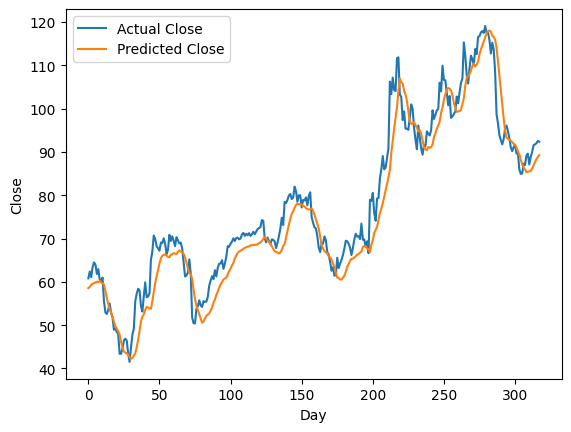

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
#export the model
torch.save(model.state_dict(), 'lstm_model.pth')
print('Model saved')

Model saved


Initial Cash: $1000
Final Portfolio Value: $1036.68
Total Profit: $36.68


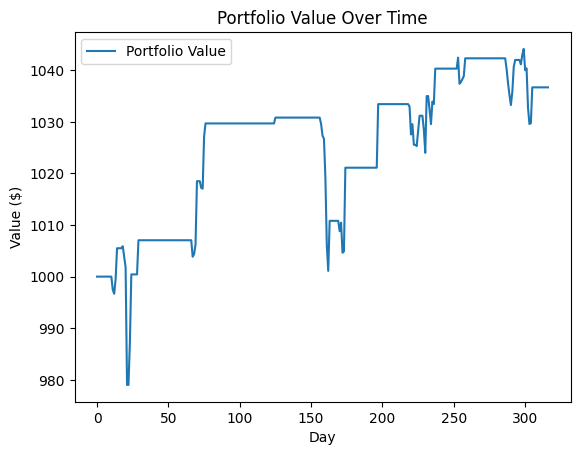

In [ ]:
initial_cash = 1000
cash = initial_cash
shares = 0
portfolio_value = []

# Parameters
buy_threshold = 1.01  # Buy if predicted price is 1% higher than current price
sell_threshold = 0.99  # Sell if predicted price is 1% lower than current price
position_size = 0.1  # Allocate 10% of cash to each trade

for i in range(1, len(new_y_test)):
    current_price = new_y_test[i]
    predicted_price = test_predictions[i]
    
    # Buy signal: Predicted price is higher than current price by the threshold
    if predicted_price > current_price * buy_threshold and cash >= current_price:
        shares_to_buy = (cash * position_size) // current_price
        shares += shares_to_buy
        cash -= shares_to_buy * current_price
    
    # Sell signal: Predicted price is lower than current price by the threshold
    elif predicted_price < current_price * sell_threshold and shares > 0:
        cash += shares * current_price
        shares = 0
    
    
    portfolio_value.append(cash + shares * current_price)


final_portfolio_value = cash + shares * new_y_test[-1]
total_profit = final_portfolio_value - initial_cash

print(f"Initial Cash: ${initial_cash}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Profit: ${total_profit:.2f}")


plt.plot(portfolio_value, label='Portfolio Value')
plt.xlabel('Day')
plt.ylabel('Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()